# Neural Bandit, a neural networks committee for the contextual bandit problem

Charles Franzen

5/9/17

## Contextual Multi-armed bandits

The contextual multi-armed bandit (MAB) problem can be quickly summarized as follows: a person is shown a context at timestep $t$ and asked to choose among $K$ actions. An action is chosen, a reward is revealed, and a new context is shown for the next timestep $t+1$. The problem is how to make a sequence of decisions about what action to take, given the context and history of contexts, actions and rewards. The goal is to maximize the payout.

<!-- TEASER_END -->

More formally, given a set of $K$ actions and a sequence of contexts $X = x_1, x_2, ..., x_t$, $x_t \in \mathbb{R}^n$ and rewards $R = r_1, r_2, ..., r_t$, $r_t \in \mathbb{R}^K$ of length $T$, choose actions at each timestep that maximize the total reward recieved.

This problem is also an *adversarial* bandit problem, because no statistical assumptions are made about the reward distribution.

In practice, rather than attempting to maximize reward, bandit algorithms attempt to minimize *regret*, which is the difference between the obtained rewards and the rewards obtained by the best possible strategy.

NOTE: I use the terms 'action' and 'arm' interchangeably.

## Dataset

The dataset I used to investigate contextual bandits is the UCI Covertype dataset. It consists of 580,000 data points, with 54 features and a target variable of 7 classes. The features represent various attributes of locations such as elevation, soil type, and amount of sunlight. The classes are forest cover types. To adapt this to the contextual bandit, the target was one-hot coded into length 7 reward vectors. The problem then is to move through the sequence of data points and make online decisions. If action 3 were selected based on some context, then only reward 3 is revealed.

In [1]:
reset -fs

In [2]:
import time
import functools
import pickle

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers

from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

Using TensorFlow backend.


## Data munging and exploratory analysis

In [3]:
col_names = [
    'elevation',
    'aspect',
    'slope',
    'h_dist_hydro',
    'v_dist_hydro',
    'h_dist_road',
    'shade_9am',
    'shade_noon',
    'shade_3pm',
    'h_dist_fire',
]

col_names += ['wild_' + str(i) for i in range(4)]
col_names += ['soil_' + str(i) for i in range(40)]
col_names.append('cover_type')

In [4]:
df = pd.read_csv('covtype.data', names=col_names)

In [5]:
# with open('soil_cover.pkl', mode='xb') as f:
#     pickle.dump(df, f)

In [6]:
df.head()

,elevation,aspect,slope,h_dist_hydro,v_dist_hydro,h_dist_road,shade_9am,shade_noon,shade_3pm,h_dist_fire,...,soil_31,soil_32,soil_33,soil_34,soil_35,soil_36,soil_37,soil_38,soil_39,cover_type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [7]:
df.describe()

,elevation,aspect,slope,h_dist_hydro,v_dist_hydro,h_dist_road,shade_9am,shade_noon,shade_3pm,h_dist_fire,...,soil_31,soil_32,soil_33,soil_34,soil_35,soil_36,soil_37,soil_38,soil_39,cover_type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [8]:
df = pd.get_dummies(df, columns=['cover_type'])

In [9]:
df = df.sample(frac=1)

In [10]:
# get X and Y
X = df.values[:, :-7]
Y = df.values[:, -7:]

In [11]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

//anaconda/envs/dl/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [12]:
Y.mean(axis=0)

array([ 0.36460521,  0.48759922,  0.06153746,  0.00472796,  0.01633873,
        0.02989095,  0.03530048])

The dataset is highly imbalanced. Arms 0 and 1 make up the vast majority of rewards.

In [13]:
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,0.550458,0.432380,0.213692,0.192862,0.283487,0.330216,0.835221,0.879208,0.561135,0.276076,...,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060
std,0.140062,0.310871,0.113458,0.152147,0.075317,0.219089,0.105393,0.077830,0.150687,0.184608,...,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.475238,0.161111,0.136364,0.077309,0.232558,0.155403,0.779528,0.838583,0.468504,0.142758,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.568784,0.352778,0.196970,0.156049,0.262274,0.280596,0.858268,0.889764,0.562992,0.238394,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.652326,0.722222,0.272727,0.274875,0.312661,0.467613,0.909449,0.933071,0.661417,0.355500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## The Neural Bandit algorithm

The algorithm that I've implemented is called Neural Bandit. I've implemented 2 iterations, henceforth called Neural Bandit 1 (NB1) and Neural Bandit 2 (NB2)

### Neural Bandit 1

This algorithm works by creating a Multilayer Perceptron (MLP) for each arm, then performing epsilon-greedy arm selection. Epsilon-greedy arm selection works by having every arm predict a reward based on an observed context, then choosing the best arm most of the time, with some probability of choosing a random arm. Once an arm has been chosen, play that arm and observe the reward. Perform a training step on the MLP for the arm played, and continue to the next timestep.

Pseudocode:

    Algorithm 1: Neural Bandit 1


    initialize a mulitlayer perceptron A_k for each action in action set K
    choose exploration parameter epsilon
    for t = 1, 2, ..., T:
        observe context x_t 
        for k in K:
            predict y_k from x_t using A_k
        perform a Bernoulli trail with success probability epsilon
        if success:
            play arm with the highest predicted reward
        else
            play a random arm 
        perform a training step on the arm played
        
### A note on optimization

The authors of Neural Bandit suggest altering the weight update equation for Stochastic Gradient Descent (SGD) by scaling the gradients by a factor $1-\gamma + \frac{\gamma}{K}$, with exploration parameter $\gamma \in (0, 1]$, and number of actions $K$. I implemented their suggestion by altering Keras' built in optimizers, but performance was unstable, so I ended up just using the optimizers as implemented by Keras and TensorFlow

In [14]:
from keras.optimizers import SGD, Adam


class Bandit_SGD(SGD):
    """Stochastic gradient descent optimizer for contextual bandits.
    Includes support for momentum,
    learning rate decay, and Nesterov momentum.
    # Arguments
        n_arms: int >0. Number of arms.
        explore: float [0., .5] Exploration parameter.
        lr: float >= 0. Learning rate.
        momentum: float >= 0. Parameter updates momentum.
        decay: float >= 0. Learning rate decay over each update.
        nesterov: boolean. Whether to apply Nesterov momentum.
    """
    
    def __init__(self, n_arms=2., explore=.1, **kwargs):
        super(Bandit_SGD, self).__init__(**kwargs)
        self.n_arms = K.variable(n_arms, name='n_arms')
        self.explore = K.variable(explore, name='explore')
    
    def get_updates(self, params, constraints, loss):
        grads = self.get_gradients(loss, params)
        self.updates = []

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * self.iterations))
            self.updates .append(K.update_add(self.iterations, 1))
        
        # weight scaling for bandits
        P = (1. - self.explore) + self.explore / self.n_arms
        # momentum
        shapes = [K.get_variable_shape(p) for p in params]
        moments = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + moments
        for p, g, m in zip(params, grads, moments):
            # apply bandit scaling
            g =  g/P
            v = self.momentum * m - lr * g  # velocity
            self.updates.append(K.update(m, v))

            if self.nesterov:
                new_p = (p + self.momentum * v - lr * g)
            else:
                new_p = (p + v)

            # apply constraints
            if p in constraints:
                c = constraints[p]
                new_p = c(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates
    
class Bandit_Adam(Adam):
    """Adam optimizer for contextual bandits
    Default parameters follow those provided in the original paper.
    # Arguments
        n_arms: int >0. Number of arms.
        explore: float [0., .5] Exploration parameter.
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor.
        decay: float >= 0. Learning rate decay over each update.
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
    """

    def __init__(self, n_arms=2., explore=.1, **kwargs):
        super(Bandit_Adam, self).__init__(**kwargs)
        self.n_arms = K.variable(n_arms, name='n_arms')
        self.explore = K.variable(explore, name='explore')
        

    def get_updates(self, params, constraints, loss):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * self.iterations))

        t = self.iterations + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        shapes = [K.get_variable_shape(p) for p in params]
        ms = [K.zeros(shape) for shape in shapes]
        vs = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + ms + vs
        # weight scaling for bandits
        P = (1. - self.explore)*(loss > -0.6931471805599453) + self.explore / self.n_arms
        
        for p, g, m, v in zip(params, grads, ms, vs):
            # apply bandit scaling
            g = g/P
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))

            new_p = p_t
            # apply constraints
            if p in constraints:
                c = constraints[p]
                new_p = c(new_p)
            self.updates.append(K.update(p, new_p))
        return self.updates

## Building NB1

In [15]:
# mlp factory

def build_experts(n, input_shape, n_hidden, n_layers):
    # builds a committee of experts
    def build_expert():
        model = Sequential()
        # add hidden layers
        for layer in range(n_layers):
            model.add(Dense(n_hidden,
                            kernel_initializer='glorot_uniform',
                            activation='relu',
                            input_dim=input_shape,
                            kernel_regularizer=regularizers.l2(0.01)))
        # output layer
        model.add(Dense(1,
                        kernel_initializer='glorot_normal',
                        activation='sigmoid',
                        kernel_regularizer=regularizers.l2(0.01)))
        return model
    experts = [build_expert() for i in range(n)]
    return experts

experts = build_experts(4, X.shape[1], 32, 1)
experts[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1760      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,793.0
Trainable params: 1,793
Non-trainable params: 0.0
_________________________________________________________________


In [16]:
def compile_experts(experts, optimizer, loss, **kwargs):
    # compiles a commitee of experts
    n_arms = len(experts)
    def compile_expert(expert, **kwargs):
        expert.compile(optimizer=optimizer,
                      loss=loss)
        return expert
    compiled_experts = [compile_expert(expert) for expert in experts]
    return compiled_experts

# test it out
experts = compile_experts(experts, 'adam', 'binary_crossentropy', explore=.1)
experts

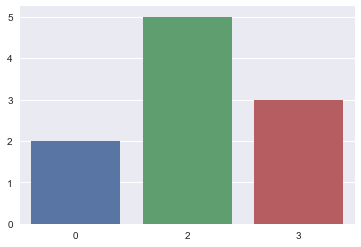

In [17]:
# chooses an arm as in Algorithm 1
def choose_arm(x, experts, explore):
    n_arms = len(experts)
    # make predictions
    preds = [expert.predict(x) for expert in experts]
    # get best arm
    arm_max = np.nanargmax(preds)
    # create arm selection probabilities
    P = [(1-explore)*(arm==arm_max) + explore/n_arms for arm in range(n_arms)]
    # select an arm
    chosen_arm = np.random.choice(np.arange(n_arms), p=P)
    pred = preds[chosen_arm]
    return chosen_arm, pred

# quick test
starting_arms = pd.value_counts([choose_arm(X[[np.random.choice(range(X.shape[0]))]], experts, explore=.5)[0] for i in range(10)])
sns.barplot(starting_arms.index, starting_arms.values);

## Running the model

I ran the models on the full dataset using a p2.xlarge GPU instance on AWS. These runs are from my local machine to show that the code works.

In [18]:
def run_bandit_1(X, Y, explore, exp_annealing_rate=1, min_explore=.005, **kwargs):
    n, n_arms = Y.shape
    input_shape = X.shape[1]
    experts = build_experts(n_arms, input_shape, 32, 1)
    experts = compile_experts(experts, **kwargs)
    # trace for arm choices
    chosen_arms = []
    # trace for regrets
    regrets = []
    true_rewards = []
    
    start_time = time.time()
    message_iteration = 10
    print(f'Starting bandit\n----------\nN_arms: {n_arms}\n----------\n')
    for i in range(n):
        context = X[[i]]
        chosen_arm, pred = choose_arm(context, experts, explore)
        reward = Y[i, chosen_arm]
        max_reward = np.max(Y[i])
        max_arm = np.argmax(Y[i])
        true_rewards.append(max_arm)
        expert = experts[chosen_arm]
        expert.fit(context, np.expand_dims(reward, axis=0), epochs=1, verbose=0)
        experts[chosen_arm] = expert
        chosen_arms.append(chosen_arm)
        regret = max_reward - reward
        regrets.append(regret)
        if explore > min_explore:
            explore *= exp_annealing_rate
        if (i % message_iteration == 0) and (i > 0):
            if message_iteration <= 1e4:
                message_iteration *= 10
            elapsed = time.time() - start_time
            remaining = (n*elapsed/i - elapsed)/60
            print(f'''Completed iteration: {i}
            Elapsed time: {elapsed:.2f} seconds
            Estimated time remaining: {remaining:.2f} minutes
            --------------------''')
    elapsed = (time.time() - start_time)/60
    print(f'Finished in: {elapsed:.2f} minutes')
    return experts, chosen_arms, true_rewards, regrets
    

In [19]:
# sample run
n_points = 100

fit_models_1, arm_hist_1, true_reward_hist_1, regret_hist_1 = run_bandit_1(X[:n_points], Y[:n_points], optimizer='adam', loss='binary_crossentropy', explore=.005, exp_annealing_rate=1, clipnorm=1.)

Starting bandit
----------
N_arms: 7
----------

Completed iteration: 10
            Elapsed time: 6.69 seconds
            Estimated time remaining: 1.00 minutes
            --------------------
Finished in: 0.16 minutes


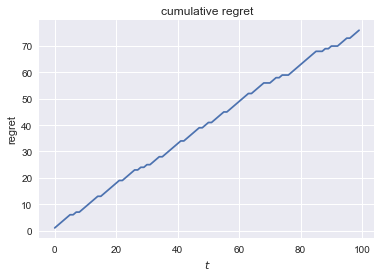

In [20]:
sns.plt.plot(np.cumsum(regret_hist_1))
sns.plt.title('cumulative regret')
sns.plt.xlabel('$t$')
sns.plt.ylabel('regret');

In [21]:
# true best arms
pd.value_counts(true_reward_hist_1)

1    50
0    34
2     8
5     4
6     3
4     1
dtype: int64

In [22]:
# chosen arms
pd.value_counts(arm_hist_1)

1    33
3    21
5    16
0    15
4    11
2     4
dtype: int64

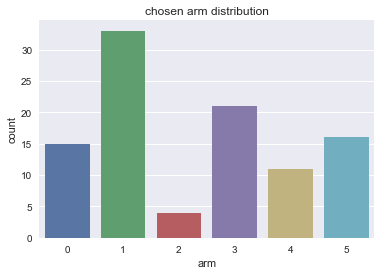

In [23]:
sns.barplot(pd.value_counts(arm_hist_1).index, pd.value_counts(arm_hist_1).values)
plt.title('chosen arm distribution')
plt.ylabel('count')
plt.xlabel('arm');

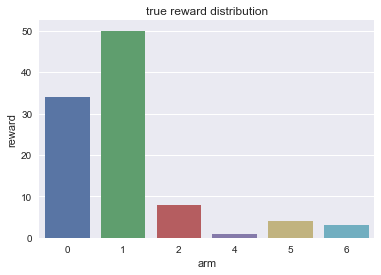

In [24]:
sns.barplot(pd.value_counts(true_reward_hist_1).index, pd.value_counts(true_reward_hist_1).values)
plt.title('true reward distribution')
plt.ylabel('reward')
plt.xlabel('arm');

## Neural Bandit 2

NB2 is an extension of NB1. Neural networks have a large number of hyperparameters, from architecture to choice of optimization algorthim to regularization. In the contextual bandit problem, however, it's not possible to grid search, since decisions must be made online and consequently only one pass through the dataset is allowed. Hyperparameter selection is instead handled by the Exp3 algorithm, which stands for "Exponential-weight algorithm for Exploration and Exploitation". This is a general algorithm for adversarial bandits. A weight vector is maintained witha weight for each action. Actions are chosen probabilistically based on the weights, with larger weighted actions having a higher probability of being chosen. There is also an exploration parameter, which determines how random the action chioce is.

With weights initialized to $w_i = 1$ for $i = 1, ..., K$, and exploration parameter $\gamma \in (0, 1]$, the probability of playing action $i$ at timestep $t$ is 

(1)
$$p_{i, t} = (1-\gamma)\frac{w_{i, t}}{\sum^K_{j=1}w_{j, t}}+\frac{\gamma}{K} $$

After action $i$ is played and reward $r_i$ is revealed, the weight of arm $i$ is updated to:

(2)
$$w_{i, t+1} = w_{i, t}\exp{\left(\frac{\gamma r_i}{p_{i, t}K}\right)} $$

This is adapted for Neural Bandit by instantiating some number of models according to NB1, varying architectures and hyperparameters, maintaining a weight vector for these models, and choosing a model to play at each timestep $t$. The arm is then chosen as in NB1 and a reward observed. *Each model* then performs a training step for the chosen arm with context $x_t$ and reward $r_{i, t}$. This way multiple models are trained online and the best model is asked to pick the arm more often as Exp3 weights evolve.

Pseudocode:

    Algorithm 2: Neural Bandit 2
    
    choose exploration parameter gamma
    create M models
    initialize M Neural Bandit 1
    initialize Exp3 weight vector to all ones
    for t in 1, 2, ..., T:
        observe context x_t
        draw m_t from P_model as in equation (1)
        model m_t chooses action k_t
        reveal reward r_kt
        perform a training step for action k_t for each model
        update the Exp3 weight for m_t as in equation (2)

In [25]:
# neural bandit 2

# get shapes and number of arms
n, n_arms = Y.shape
input_shape = X.shape[1]

# init models
# 32 hidden units, 1 hidden layer, explore = .005
model_1 = build_experts(n_arms, input_shape, n_hidden=32, n_layers=1)
model_1 = compile_experts(model_1, loss='binary_crossentropy', optimizer='adam')

# 64 hidden units, 1 hidden layer, explore = .005
model_2 = build_experts(n_arms, input_shape, n_hidden=64, n_layers=1)
model_2 = compile_experts(model_2, loss='binary_crossentropy', optimizer='adam')

# 128 hidden units, 1 hidden layer, explore = .005
model_3 = build_experts(n_arms, input_shape, n_hidden=128, n_layers=1)
model_3 = compile_experts(model_3, loss='binary_crossentropy', optimizer='adam')


# 64 hidden units, 2 hidden layers, explore = .005
model_4 = build_experts(n_arms, input_shape, n_hidden=64, n_layers=2)
model_4 = compile_experts(model_4, loss='binary_crossentropy', optimizer='adam')


# 64 hidden units, 2 hidden layers, explore = .005
model_5 = build_experts(n_arms, input_shape, n_hidden=128, n_layers=2)
model_5 = compile_experts(model_5, loss='binary_crossentropy', optimizer='adam')


# 32 hidden units, 1 hidden layer, annealing_explore
model_6 = build_experts(n_arms, input_shape, n_hidden=32, n_layers=1)
model_6 = compile_experts(model_6, loss='binary_crossentropy', optimizer='adam')

# 64 hidden units, 1 hidden layer, annealing_explore
model_7 = build_experts(n_arms, input_shape, n_hidden=64, n_layers=1)
model_7 = compile_experts(model_7, loss='binary_crossentropy', optimizer='adam')

# 128 hidden units, 1 hidden layer, annealing_explore
model_8 = build_experts(n_arms, input_shape, n_hidden=128, n_layers=1)
model_8 = compile_experts(model_8, loss='binary_crossentropy', optimizer='adam')


# 64 hidden units, 2 hidden layers, annealing_explore
model_9 = build_experts(n_arms, input_shape, n_hidden=64, n_layers=2)
model_9 = compile_experts(model_9, loss='binary_crossentropy', optimizer='adam')


# 64 hidden units, 2 hidden layers, annealing_explore
model_10 = build_experts(n_arms, input_shape, n_hidden=128, n_layers=2)
model_10 = compile_experts(model_10, loss='binary_crossentropy', optimizer='adam')

In [26]:
# set n_steps and model exploration parameter
n_steps = 100
gamma_model=.1

# collect models, only 4 in the interest of time
models = [model_2, model_4, model_7, model_9]
n_models = len(models)
# init weight vector
weights = np.ones(n_models)
# init model explore parameters
explores = np.array([.005]*2 + [.5]*2)
anneal = np.array([False]*2 + [True]*2)
annealing_rate = .99995
min_explore = .005

def get_model_probabilities(weights, gamma_model):
    # get probabilites of choosing each model
    p = np.array([(1-gamma_model)*weight/sum(weights) + gamma_model/n_models for weight in weights])
    return p

def choose_model(weights, gamma_model, model_probabilities):
    # choose a model based on weights
    n_models = len(weights)
    model = np.random.choice(np.arange(n_models), p=model_probabilities)
    return model

# init histories
arm_hist_2 = []
model_hist_2 = []
regret_hist_2 = []
weight_hist_2 = []

# init timing vars
start_time = time.time()
next_check = 1

# train the models
for step in range(n_steps):
    # store weights
    weight_hist_2.append(weights)
    # get probs and choose a model
    p = get_model_probabilities(weights, gamma_model)
    chosen_model = choose_model(weights, gamma_model, p)
    # store model choice
    model_hist_2.append(chosen_model)
    # get a random data point
    i = np.random.randint(X.shape[0])
    context = X[[i]]
    # choose an arm
    chosen_arm, pred = choose_arm(context, models[chosen_model], explores[chosen_model])
    # store arm selection
    arm_hist_2.append(chosen_arm)
    # observe reward and max reward
    reward = Y[i, chosen_arm]
    max_reward = np.max(Y[i])
    # calculate and store regret
    regret = max_reward - reward
    regret_hist_2.append(regret)
    # update the chosen arm for each model
    for m, model in enumerate(models):
        expert = model[chosen_arm]
        expert.fit(context, np.expand_dims(reward, axis=0), epochs=1, verbose=0)
        model[chosen_arm] = expert
        # anneal explore param if necessary
        if (anneal[m]) and (explores[m] > min_explore):
            explores[m] *= annealing_rate
    # update weights
    weights[chosen_model] = weights[chosen_model]*np.exp((gamma_model*reward/(p[chosen_model]*n_models)))
    # print progress
    if step == next_check:
        elapsed = time.time()-start_time
        print(f'Step {step} complete in {elapsed} seconds.')
        next_check *= 2

Step 1 complete in 23.778280019760132 seconds.
Step 2 complete in 23.80380392074585 seconds.
Step 4 complete in 34.6318678855896 seconds.
Step 8 complete in 53.786434173583984 seconds.
Step 16 complete in 62.28660321235657 seconds.
Step 32 complete in 68.92496013641357 seconds.
Step 64 complete in 69.78483510017395 seconds.


## TensorFlow implementation and multi-task learning

I had an idea for NB1 models to have a shared layer before branching for each arm, with the idea that updating shared weights would allow the other arms to learn even when they aren't chosen and therefore do not observe a context and reward. This shared layer is refered to as Multi-task learning. It was necessary to implement this in TensorFlow, and the results are somewhat promising, but I have not yet integrated this NB1 architecture into NB2. That would be a logical extension of this project.

In [27]:
# TensorFlow version of Neural Bandit 1

N_EXPERTS = 7
N_FEATURES = X.shape[1]
N_HIDDEN = 128
MAX_STEPS = len(X)
START_EXPLORE = np.array([.005])

graph2 = tf.Graph()
with graph2.as_default():
    
    # placeholders for inputs, rewards
    context = tf.placeholder(tf.float32,
                             shape=[None, N_FEATURES],
                             name='context')
    reward = tf.placeholder(tf.float32,
                            shape=[None, N_EXPERTS],
                            name='reward')
    
    # setting the exploration parameter and annealing rate
    global_step = tf.Variable(0, name='global_step', trainable=False)
    
    start_explore = tf.constant(dtype=tf.float32,
                          name='explore',
                          shape=[1],
                          value=START_EXPLORE)
    min_explore = tf.constant([.005],
                              dtype=tf.float32,
                              name='min_explore')
    
    explore_anneal = tf.constant([.99995],
                                 dtype=tf.float32,
                                 name='explore_annealing_rate')
    
    explore = start_explore * tf.pow(explore_anneal, tf.to_float(global_step + 1))
    
    explore = tf.maximum(explore, min_explore)
    
    
    # initializing regret
    cum_regret = tf.Variable([0], dtype=tf.int32, name='regret', trainable=False)
    
    
    def build_arm_network(activations, n_hidden):
        W1 = tf.Variable(tf.truncated_normal([n_hidden, n_hidden], stddev=.1),
                        dtype=tf.float32,
                        name='W1',)
        B1 = tf.Variable(tf.truncated_normal([n_hidden], stddev=.1),
                        dtype=tf.float32,
                        name='B1')
        W2 = tf.Variable(tf.truncated_normal([n_hidden, 1], stddev=.1),
                         dtype=tf.float32,
                         name='W2')
        B2 = tf.Variable(tf.truncated_normal([1], stddev=.1),
                         dtype=tf.float32,
                         name='B2')
        h1 = tf.matmul(activations, W1) + B1
        a1 = tf.nn.relu(h1)
        h2 = tf.matmul(a1, W2) + B2
        return h2
    
    def loss_fn(target, y_hat):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=target,
                                                            logits=y_hat,
                                                            name='xentropy')
        loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
        return loss
    
    # dense layer variables
    W_shared = tf.Variable(tf.truncated_normal([N_FEATURES, N_HIDDEN], stddev=.1),
                           dtype=tf.float32,
                           name='shared_weights',)

    B_shared = tf.Variable(tf.truncated_normal([N_HIDDEN], stddev=.1),
                           dtype=tf.float32,
                           name='shared_biases')
    
    h_shared = tf.matmul(context, W_shared) + B_shared
    a_shared = tf.nn.relu(h_shared)
    
    y_hats = []
    for exp in range(N_EXPERTS):
        
        # arm networks
        with tf.variable_scope('arm_'+str(exp)):
            h = build_arm_network(a_shared, N_HIDDEN)
            y_hat = tf.nn.sigmoid(h, name='y_hat')
            y_hats.append(y_hat)
            loss = loss_fn(tf.slice(reward, begin=[0, exp], size=[1, 1]), y_hat)

            # track losses
            tf.summary.scalar('loss', loss)
        
        
    # aggregate predictions for epsilon greedy
    y_hats = tf.squeeze(tf.concat(y_hats, axis=0))
    
    # epsilon greedy arm choice
    best_arm = tf.arg_max(y_hats, dimension=0)
    best_arm_probs = tf.expand_dims(tf.concat([explore, 1 - explore], axis=0), 0)
    best_arm_draw = tf.squeeze(tf.multinomial(tf.log(best_arm_probs), 1))
    
    def best_arm_fn():
        return best_arm
    
    def random_arm():
        counts = tf.ones([1, N_EXPERTS])
        logs = tf.log(counts)
        return tf.squeeze(tf.multinomial(logs, 1))
    
    chosen_arm = tf.cond(tf.equal(best_arm_draw, tf.ones_like(best_arm_draw)), # condition
                                  best_arm_fn, # if True
                                  random_arm) # if False
    
    tf.summary.histogram('chosen_arms', chosen_arm)
    
    # track regret
    true_best_arm = tf.arg_max(reward, dimension=1)
    regret = tf.logical_not(tf.equal(chosen_arm, true_best_arm))
    cum_regret = tf.assign(cum_regret, (tf.add(tf.to_int32(regret), cum_regret)))
    tf.summary.scalar('cumulative_regret', tf.squeeze(cum_regret))
    
    
    # create optimizers and training ops for each arm
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    update_ops.append(cum_regret)
    with tf.control_dependencies(update_ops):
        optimizers = [tf.train.AdamOptimizer() for _ in range(N_EXPERTS)]
        
        train_ops = []
        for exp in range(N_EXPERTS):
            with tf.variable_scope('arm'+str(exp)):
                train_ops.append(optimizers[exp].minimize(loss, global_step))
    
    def train_op(arm):
        return train_ops[arm]
    
    # tensorboard logs
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter(graph=graph2, logdir='./neural_bandit_1')

    
    init_op = tf.global_variables_initializer()


In [28]:
with tf.Session(graph=graph2) as sess:
    sess.run(init_op)
    for step in range(1000):
        i = np.random.randint(X.shape[0])
        feed_dict={context: X[[i]], reward: Y[[i]]}
        chosen_arm_, y_hats_= sess.run([chosen_arm, y_hats], feed_dict=feed_dict)
        if step % 100 == 0:
            summary, _, regret_, explore_ = sess.run([merged, train_op(chosen_arm_), cum_regret, explore], feed_dict=feed_dict)
            writer.add_summary(summary, step)
            print('at step {}, regret was {} and explore was {}'.format(step, regret_, explore_))
        else:
            sess.run([train_op(chosen_arm_)], feed_dict=feed_dict)


at step 0, regret was [0] and explore was [ 0.005]
at step 100, regret was [92] and explore was [ 0.005]
at step 200, regret was [184] and explore was [ 0.005]
at step 300, regret was [270] and explore was [ 0.005]
at step 400, regret was [368] and explore was [ 0.005]
at step 500, regret was [467] and explore was [ 0.005]
at step 600, regret was [561] and explore was [ 0.005]
at step 700, regret was [661] and explore was [ 0.005]
at step 800, regret was [758] and explore was [ 0.005]
at step 900, regret was [858] and explore was [ 0.005]


## Experimental Results

Again, I fit the models using AWS GPU instances configured with the BitFusion Ubuntu 14 AMI. NB1 with a shared layer achieved an average regret of .409 per timestep over 100,000 timesteps, diminishing to .318 after 2 million. NB2 with 4 models, each varying the number of hidden units and number of hidden layers, acheived an average regret of .385 per timestep after 100,000 timesteps. Random arm choice gives an average regret of .857. There are numerical stability issues with the Exp3 algorithm, as weights have a tendency to overflow, limiting the number of timesteps that can be run. Dividing the weights by the lowest weight at set intervals can constrain the weights somewhat, but if the difference in performance between the best and worst model is too large the weights still run into overflow. See the regret trajectories below.

![alt text](nb2_chosen_arms.png)

![alt text](true_rewards.png)

![alt text](nb2_regret.png)


## Further research

Shared layers should be incorporated into NB2 models. The authors of Neural Bandit also suggest Neural Bandit 3, in which a separate Exp3 instance is maintained for each arm. NB3 was theorized to be more robust to nonstationarity. Variants of Exp3 should be tried as well, and there are many.

## References

* Auer, Peter, et al. "The nonstochastic multiarmed bandit problem." SIAM journal on computing 32.1 (2002): 48-77.

* https://jeremykun.com/2013/11/08/adversarial-bandits-and-the-exp3-algorithm/

* Allesiardo, Robin, Raphaël Féraud, and Djallel Bouneffouf. "A neural networks committee for the contextual bandit problem." International Conference on Neural Information Processing. Springer International Publishing, 2014.

* Caruana, Rich. "Multitask learning." Learning to learn. Springer US, 1998. 95-133.